# Assignment 7

In this assignment, you are expected to write your own collision avoidance system that works in the presence of uncertainty. These will be evaluated identically to the previous collision avoidance systems.

Your collision avoidance system will now the `update!` method receives a `SensorReading` instead of the true aircraft states.

![Encounter Definition](../04_Learning/figures/encounter_def.png)

A `SensorReading` contains:
- $r$ - the horizontal distance between the aircraft, in feet
- $\alpha$ - the bearing, in degrees, from aircraft 1 towards aircraft 2. A bearing of zero point down aircraft 1's nose and positive bearing values increase towards aircraft one's left wing.
- $d$ - the discretized relative altitude of aircraft 2 with respect to aircraft 1.

You thus have access to three pieces of information - the range, the bearing, and the altitude. 

The range is computed using the true range plus zero-mean Gaussian noise with a $50 \text{ft}$ standard deviation. The bearing is computed using the true bearing plus zero-mean Gaussian noise with a $5$ degree standard deviation

The altitude is discretized into the following bins but includes no noise:

$$
\begin{cases}
    \text{relative altitude} \in (-\inf, -1000] \> \text{ft} & \rightarrow \> d = 1 \\
    \text{relative altitude} \in (-1000, -500] \> \text{ft} & \rightarrow \> d = 2 \\
    \text{relative altitude} \in (-500, -250] \> \text{ft} & \rightarrow \> d = 3 \\
    \text{relative altitude} \in (-250, -100] \> \text{ft} & \rightarrow \> d = 4 \\
    \text{relative altitude} \in (-100,  0] \> \text{ft} & \rightarrow \> d = 5 \\
    \text{relative altitude} \in (0, 100] \> \text{ft} & \rightarrow \> d = 6 \\
    \text{relative altitude} \in (100, 250] \> \text{ft} & \rightarrow \> d = 7 \\
    \text{relative altitude} \in (250, 500] \> \text{ft} & \rightarrow \> d = 8 \\
    \text{relative altitude} \in (500, \inf] \> \text{ft} & \rightarrow \> d = 9
\end{cases}
$$

### What is Turned In

Write all of your code in a file structured identically to "my_cas.jl" and turn it in to Coursework.

In [1]:
using AA120Q
plotlyjs()

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/AA120Q.ji for module AA120Q.


Here is a dataset of fully-human encounters, which you can then use to collect your own set of encounters to evaluate your Collision Avoidance System (CAS).

In [2]:
initial, traces = get_dataset("small")
encounters = pull_encounters(initial, traces, 500);

## Demonstrative Partially Observable Collision Avoidance System - (DCAS)

Here is a demonstrative collision avoidance system, which is a fully-functional out-of-the-box CAS. It will leverage the model and the AA120Q API. The two functions reset() and update() are implemented here. Use it as a starting point to design your own CAS.

The model will issue an Advisory (or none) at each timestep. Issuing ADVISORY_NONE or your previous advisory is equivalent to issuing no advisory.

In [3]:
type DemoCAS2 <: PartiallyObservableCollisionAvoidanceSystem
    range_threshold::Float64
    last_advisory::Advisory
    DemoCAS2(range_threshold::Float64, last_advisory::Advisory=ADVISORY_NONE) = new(range_threshold, last_advisory)
end

A reset function to start it anew

In [4]:
function AA120Q.reset!(dcas::DemoCAS2)
    dcas.last_advisory = ADVISORY_NONE
    dcas
end

reset! (generic function with 3 methods)

The update function issues an advisory. Note that we now get a `SensorReading`.

In [5]:
function AA120Q.update!(dcas::DemoCAS2, reading::SensorReading, params::EncounterSimParams)
    
    range = reading.r # range [ft]

    # test for activation
    if is_no_advisory(dcas.last_advisory) && range < dcas.range_threshold
        dcas.last_advisory = Advisory(CLIMB_RATE_MAX) # climb!
    end
        
    dcas.last_advisory
end

update! (generic function with 5 methods)

You can now simulate trajectories with your custom CAS...

[Plots.jl] Initializing backend: pyplot


Gtk-Message: Failed to load module "overlay-scrollbar"



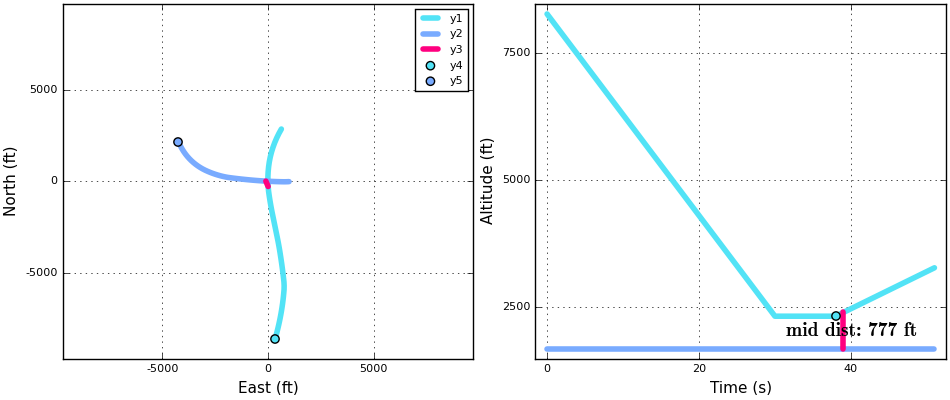

/home/tim/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/tim/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/tim/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1292: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


In [6]:
srand(0)
enc = rand(encounters[1], DemoCAS2(1000.0))
plot_encounter(enc)

# Pull Evaluation Metrics

Use `evaluate` to report the number of advisories and near midair collisions (NMACs). Remember that a good safety system will minimize both the number of collisions and the number of alerts. We will measure performance based on the average cost per trajectory, `CASEval.normalized`. Try to minimize it!

In [22]:
# run every encounter once
evaluate(DemoCAS2(1000.0), encounters)

CASEval(n_encounters: 3, n_advisories: 3, n_NMACs: 0, penalty: 400.00, normalized: 133.33)

In [23]:
# randomly sample 50 encounters from `encounters`
evaluate(DemoCAS2(1000.0), encounters, 50)

CASEval(n_encounters: 50, n_advisories: 50, n_NMACs: 0, penalty: 6666.67, normalized: 133.33)